<a href="https://colab.research.google.com/github/mb925/FeaturesFunctions/blob/main/Copia_di_Repeats_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRs disease association vs background distributions: UniProt and PDB

In [3]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def how_many(elements):
    list_pdb = []
    for uniprot in elements:
        if isinstance(uniprot, str):
            for pdb in uniprot.split(';'):
                if pdb not in list_pdb and pdb != '':
                    list_pdb.append(pdb)
    return len(list_pdb)

def how_many_merge_classes(trp_class1, trp_class2):
    trp_unique_1 = trp_class1['Entry'].drop_duplicates().to_frame()
    trp_unique_2 = trp_class2['Entry'].drop_duplicates().to_frame()
    trp_unique_all = trp_unique_1.merge(trp_unique_2, how='inner', on='Entry')
    return len(trp_unique_all.index)


def how_many_trp(trp_classes, df_human_reference, df_swissprot, df_human):
    trp_unique_all = trp_classes.drop_duplicates(subset='Entry', keep="first")
    trp_all = len(trp_unique_all.index)
    trp_unique_human = trp_classes.loc[(trp_classes.Organism == 'Homo sapiens (Human)')].drop_duplicates(subset='Entry', keep="first")
    trp_human_reference = trp_unique_human.merge(df_human_reference, on=['Entry'], how='inner')
    trp_human_swissprot = trp_unique_human.merge(df_swissprot, on=['Entry'], how='inner')
    trp_human = trp_unique_human.merge(df_human, on=['Entry'], how='inner')
    trp_human_reference = len(trp_human_reference.index)
    trp_human_swissprot = len(trp_human_swissprot.index)
    trp_human = len(trp_human.index)
    trp_pdb_all = trp_unique_all['Cross-reference (PDB)'].tolist()
    trp_pdb_human = trp_unique_human['Cross-reference (PDB)'].tolist()
    trp_pdb_all = how_many(trp_pdb_all)
    trp_pdb_human = how_many(trp_pdb_human)
    trp_omim = len(trp_unique_all['Involvement in disease'].dropna().index)
    return [trp_all, trp_human_reference, trp_pdb_all, trp_pdb_human, trp_omim, trp_human_swissprot, trp_human]

def merge_left_only(df_uniprot, df_repeats):
    df = pd.merge(df_uniprot, df_repeats, on=['Entry'], how="outer", indicator=True).query(
        '_merge=="left_only"')
    cols = [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
    df.drop(df.columns[cols], axis=1, inplace=True)
    df.columns = df_uniprot.columns
    df_uniprot.update(df)
    return df

In [ ]:
def table_count():
    df_uniprots_reference = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/uniprot_referenceproteome.tsv', sep='\t')
    df_uniprots_swissprot = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/uniprot-homosapiens-swissprot.tsv', sep='\t')
    df_uniprots = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/uniprot-advancedseach-homosapiens.tsv', sep='\t')


    df_pdbs = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/pdb_chain_uniprot.tsv', sep='\t')
    df_repeats_classification = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/repeatsdb_type_classification.tsv', sep='\t', index_col=0).drop_duplicates()
    df_repeats = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/repeatsdb_type_disease.tsv', sep='\t')
    df_trp_dis = df_repeats.loc[(df_uniprots_reference.Organism == 'Homo sapiens (Human)')][df_repeats['Involvement in disease'].notna()]



    # remove repeats from uniprot databases
    df_uniprots_reference = merge_left_only(df_uniprots_reference, df_repeats)
    df_uniprots_swissprot = merge_left_only(df_uniprots_swissprot, df_repeats)
    df_uniprots = merge_left_only(df_uniprots, df_repeats)

    # UniProt
    uniprot_pdb = len(df_pdbs['Entry'].drop_duplicates().index) # uniprot with at least 1 pdb associated
    df_uniprot_human_reference = df_uniprots_reference.loc[(df_uniprots_reference.Organism == 'Homo sapiens (Human)')]
    uniprot_pdb_human = len(df_uniprot_human_reference.merge(df_pdbs, on=['Entry'], how='inner')['Entry'].drop_duplicates().index)
    df_uniprot_human_swissprot = df_uniprots_swissprot.loc[(df_uniprots_swissprot.Organism == 'Homo sapiens (Human)')]
    df_uniprot_human = df_uniprots.loc[(df_uniprots.Organism == 'Homo sapiens (Human)')]
    uniprot_human_reference = len(df_uniprot_human_reference.index)
    uniprot_human_swissprot = len(df_uniprot_human_swissprot.index)
    uniprot_human = len(df_uniprot_human.index)
    uniprot_pdb_merge = df_uniprot_human_reference.merge(df_pdbs, on=['Entry'], how='inner')
    pdb_human = len(uniprot_pdb_merge.drop_duplicates(subset=['PDB', 'CHAIN'], keep="first").index)

    # TRP
    uniprot_human_trp = len(df_repeats.loc[(df_repeats.Organism == 'Homo sapiens (Human)')]['Entry'].index)

    # DISEASE
    uniprot_all_omim = 5147  # fonte: uniprot search by disease
    uniprot_disease_reference = len(df_uniprots_reference.loc[(df_uniprots_reference.Organism == 'Homo sapiens (Human)')][
                                    'Involvement in disease'].dropna().index)  # info matching with: uniprot search by disease and organism
    uniprot_disease_human = len(df_uniprots.loc[(df_uniprots.Organism == 'Homo sapiens (Human)')][
                                    'Involvement in disease'].dropna().index)
    uniprot_disease_swissprot = len(df_uniprots_swissprot.loc[(df_uniprots_swissprot.Organism == 'Homo sapiens (Human)')][
                                    'Involvement in disease'].dropna().index)

    uniprot_trp_dis = len(df_trp_dis['Entry'].index)
    uniprot_trp_dis_human = len(df_repeats.loc[(df_uniprots_reference.Organism == 'Homo sapiens (Human)')]['Involvement in disease'].dropna().index)


    # TRP CLASSES

    trp_ii_classes = df_repeats_classification.loc[(df_repeats_classification['Classification'] >= 2) & (df_repeats_classification['Classification'] <= 2.9)]
    [trp_ii_all, trp_ii_reference, trp_ii_pdb_all, trp_ii_pdb_human, trp_ii_omim, trp_ii_swissprot, trp_ii_human] = how_many_trp(trp_ii_classes, df_uniprots_reference, df_uniprots_swissprot, df_uniprots)


    trp_iii_classes = df_repeats_classification.loc[(df_repeats_classification['Classification'] >= 3) & (df_repeats_classification['Classification'] <= 3.9)]
    [trp_iii_all, trp_iii_reference, trp_iii_pdb_all, trp_iii_pdb_human, trp_iii_omim, trp_iii_swissprot, trp_iii_human] = how_many_trp(trp_iii_classes, df_uniprots_reference, df_uniprots_swissprot, df_uniprots)


    trp_iv_classes = df_repeats_classification.loc[(df_repeats_classification['Classification'] >= 3) & (df_repeats_classification['Classification'] <= 4.9)]
    [trp_iv_all, trp_iv_reference, trp_iv_pdb_all, trp_iv_pdb_human, trp_iv_omim, trp_iv_swissprot, trp_iv_human] = how_many_trp(trp_iv_classes, df_uniprots_reference, df_uniprots_swissprot, df_uniprots)

    trp_v_classes = df_repeats_classification.loc[(df_repeats_classification['Classification'] >= 5) & (df_repeats_classification['Classification'] <= 5.9)]
    [trp_v_all, trp_v_reference, trp_v_pdb_all, trp_v_pdb_human, trp_v_omim, trp_v_swissprot, trp_v_human] = how_many_trp(trp_v_classes, df_uniprots_reference, df_uniprots_swissprot, df_uniprots)

    pdb_all = len(df_pdbs.drop_duplicates(subset=['PDB', 'CHAIN'], keep="first").index)

    trp_pdb_omim = df_repeats['Cross-reference (PDB)'].tolist()
    trp_pdb_omim = how_many(trp_pdb_omim)

    trp_ii_pdb_omim = trp_ii_classes.drop_duplicates(subset='Entry', keep="first")['Cross-reference (PDB)'].tolist()
    trp_ii_pdb_omim = how_many(trp_ii_pdb_omim)
    trp_iii_pdb_omim = trp_iii_classes.drop_duplicates(subset='Entry', keep="first")['Cross-reference (PDB)'].tolist()
    trp_iii_pdb_omim = how_many(trp_iii_pdb_omim)
    trp_iv_pdb_omim = trp_iv_classes.drop_duplicates(subset='Entry', keep="first")['Cross-reference (PDB)'].tolist()
    trp_iv_pdb_omim = how_many(trp_iv_pdb_omim)
    trp_v_pdb_omim = trp_v_classes.drop_duplicates(subset='Entry', keep="first")['Cross-reference (PDB)'].tolist()
    trp_v_pdb_omim = how_many(trp_v_pdb_omim)


    # TRP CLASSES INTERSECTIONS

    trp_ii_iii = how_many_merge_classes(trp_ii_classes, trp_iii_classes)
    trp_ii_iv = how_many_merge_classes(trp_ii_classes, trp_iv_classes)
    trp_ii_v = how_many_merge_classes(trp_ii_classes, trp_v_classes)
    trp_iii_iv = how_many_merge_classes(trp_iii_classes, trp_iv_classes)
    trp_iii_v = how_many_merge_classes(trp_iii_classes, trp_v_classes)
    trp_iv_v = how_many_merge_classes(trp_iv_classes, trp_v_classes)


    # Filling the matrix
    w, h = 17, 17
    matrix = [[0 for x in range(w)] for y in range(h)]

    # PDB all
    matrix[0][0] = pdb_all # PDB all
    matrix[0][1] = pdb_human  # PDB Human
    matrix[0][2] = uniprot_pdb # UniProt all
    matrix[0][3] = uniprot_pdb_human  # UniProt Human reference
    matrix[0][4] = 0 # TRP UniProt
    matrix[0][5] = 0 # OMIM UniProt
    matrix[0][6] = 0 # TRP II
    matrix[0][7] = 0 # TRP III
    matrix[0][8] = 0 # TRP IV
    matrix[0][9] = 0 # TRP V
    matrix[0][10] = trp_ii_pdb_all + trp_iii_pdb_all + trp_iv_pdb_all + trp_v_pdb_all # TRP PDB
    matrix[0][11] = trp_ii_pdb_all # TRP II PDB
    matrix[0][12] = trp_iii_pdb_all # TRP III PDB
    matrix[0][13] = trp_iv_pdb_all # TRP IV PDB
    matrix[0][14] = trp_iv_pdb_all # TRP V PDB
    matrix[0][15] = 0 # UniProt Human SwissProt
    matrix[0][16] = 0 # UniProt Human

    # PDB Human
    matrix[1][1] = 0 # PDB Human
    matrix[1][2] = 0 # UniProt all
    matrix[1][3] = 0 # UniProt Human reference
    matrix[1][4] = 0 # TRP UniProt
    matrix[1][5] = 0 # OMIM UniProt
    matrix[1][6] = 0 # TRP II
    matrix[1][7] = 0 # TRP III
    matrix[1][8] = 0 # TRP IV
    matrix[1][9] = 0 # TRP V
    matrix[1][10] = trp_ii_pdb_human + trp_iii_pdb_human + trp_iv_pdb_human + trp_v_pdb_human # TRP PDB
    matrix[1][11] = trp_ii_pdb_human # TRP II PDB
    matrix[1][12] = trp_iii_pdb_human # TRP III PDB
    matrix[1][13] = trp_iv_pdb_human # TRP IV PDB
    matrix[1][14] = trp_v_pdb_human # TRP V PDB
    matrix[1][15] = 0  # UniProt Human SwissProt
    matrix[1][16] = 0  # UniProt Human

    # UniProt all
    matrix[2][2] = 0 # UniProt all
    matrix[2][3] = uniprot_human_reference # UniProt Human reference
    matrix[2][4] = trp_ii_all + trp_iii_all + trp_iv_all + trp_v_all # TRP UniProt
    matrix[2][5] = uniprot_all_omim # OMIM UniProt
    matrix[2][6] = trp_ii_all # TRP II
    matrix[2][7] = trp_iii_all # TRP III
    matrix[2][8] = trp_iv_all # TRP IV
    matrix[2][9] = trp_v_all # TRP V
    matrix[2][10] = 0 # TRP PDB
    matrix[2][11] = 0 # TRP II PDB
    matrix[2][12] = 0 # TRP III PDB
    matrix[2][13] = 0 # TRP IV PDB
    matrix[2][14] = 0 # TRP V PDB
    matrix[2][15] = uniprot_human_swissprot  # UniProt Human SwissProt
    matrix[2][16] = uniprot_human  # UniProt Human

    # 'UniProt Human'
    matrix[3][3] = uniprot_human_reference # UniProt Human reference
    matrix[3][4] = uniprot_human_trp # TRP UniProt
    matrix[3][5] = uniprot_disease_reference # OMIM UniProt
    matrix[3][6] = trp_ii_reference # TRP II UniProt
    matrix[3][7] = trp_iii_reference # TRP III UniProt
    matrix[3][8] = trp_iv_reference # TRP IV UniProt
    matrix[3][9] = trp_v_reference # TRP V UniProt
    matrix[3][10] = 0 # TRP PDB
    matrix[3][11] = 0 # TRP II PDB
    matrix[3][12] = 0 # TRP III PDB
    matrix[3][13] = 0 # TRP IV PDB
    matrix[3][14] = 0 # TRP V PDB
    matrix[3][15] = 0  # UniProt Human SwissProt
    matrix[3][16] = 0  # UniProt Human

    # TRP UniProt
    matrix[4][4] = trp_ii_all + trp_iii_all + trp_iv_all + trp_v_all # TRP UniProt
    matrix[4][5] = uniprot_trp_dis # OMIM UniProt
    matrix[4][6] = trp_ii_all # TRP II
    matrix[4][7] = trp_iii_all # TRP III
    matrix[4][8] = trp_iv_all # TRP IV
    matrix[4][9] = trp_v_all # TRP V
    matrix[4][10] = trp_ii_all + trp_iii_all + trp_iv_all + trp_v_all # TRP PDB
    matrix[4][11] = 0 # TRP II PDB
    matrix[4][12] = 0 # TRP III PDB
    matrix[4][13] = 0 # TRP IV PDB
    matrix[4][14] = 0 # TRP V PDB
    matrix[4][15] = 0  # UniProt Human SwissProt
    matrix[4][16] = 0  # UniProt Human

    # OMIM UniProt
    matrix[5][5] = 0
    matrix[5][6] = trp_ii_omim
    matrix[5][7] = trp_iii_omim
    matrix[5][8] = trp_iv_omim
    matrix[5][9] = trp_v_omim
    matrix[5][10] = trp_pdb_omim # TRP PDB
    matrix[5][11] = trp_ii_pdb_omim # TRP II PDB
    matrix[5][12] = trp_iii_pdb_omim # TRP III PDB
    matrix[5][13] = trp_iv_pdb_omim # TRP IV PDB
    matrix[5][14] = trp_v_pdb_omim # TRP V PDB
    matrix[5][15] = uniprot_disease_swissprot  # UniProt Human SwissProt
    matrix[5][16] = uniprot_disease_human  # UniProt Human

    # TRP II UniProt
    matrix[6][6] = trp_ii_all
    matrix[6][7] = trp_ii_iii
    matrix[6][8] = trp_ii_iv
    matrix[6][9] = trp_ii_v
    matrix[6][10] = 0  # TRP PDB
    matrix[6][11] = 0  # TRP II PDB
    matrix[6][12] = 0  # TRP III PDB
    matrix[6][13] = 0  # TRP IV PDB
    matrix[6][14] = 0  # TRP V PDB
    matrix[6][15] = 0  # UniProt Human SwissProt
    matrix[6][16] = 0  # UniProt Human

    # TRP III UniProt
    matrix[7][7] = trp_iii_all
    matrix[7][8] = trp_iii_iv
    matrix[7][9] = trp_iii_v
    matrix[7][10] = 0  # TRP PDB
    matrix[7][11] = 0  # TRP II PDB
    matrix[7][12] = 0  # TRP III PDB
    matrix[7][13] = 0  # TRP IV PDB
    matrix[7][14] = 0  # TRP V PDB
    matrix[7][15] = 0  # UniProt Human SwissProt
    matrix[7][16] = 0  # UniProt Human

    # TRP IV UniProt
    matrix[8][8] = trp_iv_all
    matrix[8][9] = trp_iv_v
    matrix[8][10] = 0  # TRP PDB
    matrix[8][11] = 0  # TRP II PDB
    matrix[8][12] = 0  # TRP III PDB
    matrix[8][13] = 0  # TRP IV PDB
    matrix[8][14] = 0  # TRP V PDB
    matrix[8][15] = 0  # UniProt Human SwissProt
    matrix[8][16] = 0  # UniProt Human

    # TRP V UniProt
    matrix[9][9] = trp_v_all
    matrix[9][10] = 0  # TRP PDB
    matrix[9][11] = 0  # TRP II PDB
    matrix[9][12] = 0  # TRP III PDB
    matrix[9][13] = 0  # TRP IV PDB
    matrix[9][14] = 0  # TRP V PDB
    matrix[9][15] = 0  # UniProt Human SwissProt
    matrix[9][16] = 0  # UniProt Human

    # TRP PDB
    matrix[10][10] = trp_ii_pdb_all + trp_iii_pdb_all + trp_iv_pdb_all + trp_v_pdb_all  # TRP PDB
    matrix[10][11] = trp_ii_pdb_all  # TRP II PDB
    matrix[10][12] = trp_iii_pdb_all  # TRP III PDB
    matrix[10][13] = trp_iv_pdb_all  # TRP IV PDB
    matrix[10][14] = trp_v_pdb_all  # TRP V PDB
    matrix[10][15] = 0  # UniProt Human SwissProt
    matrix[10][16] = 0  # UniProt Human

    # TRP II PDB
    matrix[11][11] = trp_ii_pdb_all  # TRP II PDB
    matrix[11][12] = trp_iii_pdb_all  # TRP III PDB
    matrix[11][13] = trp_iv_pdb_all  # TRP IV PDB
    matrix[11][14] = trp_v_pdb_all  # TRP V PDB
    matrix[11][15] = trp_ii_swissprot  # UniProt Human SwissProt
    matrix[11][16] = trp_ii_human  # UniProt Human

    # TRP III PDB
    matrix[12][12] = trp_iii_pdb_all  # TRP III PDB
    matrix[12][13] = trp_iv_pdb_all  # TRP IV PDB
    matrix[12][14] = trp_v_pdb_all  # TRP V PDB
    matrix[12][15] = trp_iii_swissprot  # UniProt Human SwissProt
    matrix[12][16] = trp_iii_human  # UniProt Human

    # TRP IV PDB
    matrix[13][13] = trp_iv_pdb_all  # TRP IV PDB
    matrix[13][14] = trp_v_pdb_all  # TRP V PDB
    matrix[13][15] = trp_iv_swissprot  # UniProt Human SwissProt
    matrix[13][16] = trp_iv_human  # UniProt Human

    # TRP V PDB
    matrix[14][14] = trp_v_pdb_all  # TRP V PDB
    matrix[14][15] = trp_v_swissprot  # UniProt Human SwissProt
    matrix[14][16] = trp_v_human  # UniProt Human

    # UniProt Human Swissprot
    matrix[15][15] = uniprot_human_swissprot  # UniProt Human SwissProt
    matrix[15][16] = 0  # UniProt Human

    # # UniProt Human
    matrix[16][16] = uniprot_human  # UniProt Human

    label = ['PDB all', 'PDB Human', 'UniProt all', 'UniProt Human reference', 'TRP human UniProt', 'OMIM UniProt', 'TRP II', 'TRP III', 'TRP IV', 'TRP V', 'TRP PDB', 'TRP II PDB', 'TRP III PDB', 'TRP IV PDB', 'TRP V PDB', 'UniProt Swissprot', 'Uniprot Human']
    df_count_disease = pd.DataFrame(matrix, columns=label)
    df_count_disease.index = label
    df_count_disease.to_csv('drive/MyDrive/Colab Notebooks/output/contingency_table.tsv', sep='\t')

In [ ]:
table_count()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2828: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2828: DtypeWarning: Columns (7,8,9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
stk = pd.read_csv('drive/MyDrive/Colab Notebooks/output/contingency_table.tsv', sep='\t', index_col=0) #to read the file
stk

,PDB all,PDB Human,UniProt all,UniProt Human reference,TRP human UniProt,OMIM UniProt,TRP II,TRP III,TRP IV,TRP V,TRP PDB,TRP II PDB,TRP III PDB,TRP IV PDB,TRP V PDB,UniProt Swissprot,Uniprot Human
PDB all,297680,67274,35787,4868,0,0,0,0,0,0,16786,340,5042,10299,10299,0,0
PDB Human,0,0,0,0,0,0,0,0,0,0,6858,20,2330,3778,730,0,0
UniProt all,0,0,0,78758,2249,5147,21,702,1426,100,0,0,0,0,0,203431,78758
UniProt Human reference,0,0,0,78758,280,4510,0,0,0,0,0,0,0,0,0,0,0
TRP human UniProt,0,0,0,0,2249,105,21,702,1426,100,2249,0,0,0,0,0,0
OMIM UniProt,0,0,0,0,0,0,1,59,84,26,11217,340,5042,10299,1105,4510,4510
TRP II,0,0,0,0,0,0,21,11,15,2,0,0,0,0,0,0,0
TRP III,0,0,0,0,0,0,0,702,702,8,0,0,0,0,0,0,0
TRP IV,0,0,0,0,0,0,0,0,1426,21,0,0,0,0,0,0,0
TRP V,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0


**Diseases in TRP vs UniProt**
			
				

In [ ]:
import scipy.stats as stats
import pandas as pd
import seaborn as sn
import io
import numpy as np
import matplotlib.pyplot as plt
def disease_in_proteins():
    table = pd.read_csv('drive/MyDrive/Colab Notebooks/output/contingency_table.tsv', sep='\t', index_col=0)
    # Disease in UniProt Human proteins
    omim_uniprot = table.at['UniProt Human reference', 'OMIM UniProt']
    uniprot_human_ref = table.at['UniProt Human reference', 'UniProt Human reference']
    disease_uniprot_human = (omim_uniprot / uniprot_human_ref) * 100
    non_disease_uniprot_human = 100 - disease_uniprot_human
    print("Disease in UniProt Human proteins: " + str(round(disease_uniprot_human, 2)))
    omim_uniprot = table.at['TRP human UniProt', 'OMIM UniProt']
    trp_human_ref = table.at['UniProt Human reference', 'TRP human UniProt']
    disease_trp_human = (omim_uniprot / trp_human_ref) * 100
    non_disease_trp_human = 100 - disease_trp_human
    print("Disease in TRP Human proteins: " + str(round(disease_trp_human, 2)))

    omim_trp = table.at['TRP human UniProt', 'OMIM UniProt']
    no_omim_trp = table.at['TRP human UniProt', 'TRP human UniProt'] - table.at['TRP human UniProt', 'OMIM UniProt']
    no_omim_uniprot = table.at['UniProt Human reference', 'UniProt Human reference'] - table.at['UniProt Human reference', 'OMIM UniProt']
    oddsratio, pvalue = stats.fisher_exact([[omim_trp, omim_uniprot], [no_omim_trp, no_omim_uniprot]])
    print("Fisher exact test p-value " + str(pvalue))

    # Mosaic plot
    conf_arr = np.array([[disease_trp_human, disease_uniprot_human],
                         [non_disease_trp_human, non_disease_uniprot_human]])

    df_cm = pd.DataFrame(conf_arr,
                         index=['DISEASE', 'NON DISEASE'],
                         columns=['TRP', 'UNIPROT'])

    fig = plt.figure()

    plt.clf()

    ax = fig.add_subplot(111)

    ax.set_aspect(1)
    res = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f')
    plt.yticks([0.5, 1.5], ['DISEASE', 'NON DISEASE'], va='center')

    plt.title('''Disease in proteins \n Repeat vs non repeat''')

    plt.show()


Disease in UniProt Human proteins: 5.73
Disease in TRP Human proteins: 37.5
Fisher exact test p-value 5.566311790966537e-102


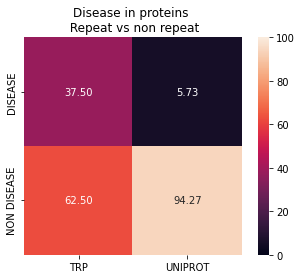

In [ ]:
disease_in_proteins()

**Disease distribution by class (TRP)**

In [ ]:
def disease_by_class():
    # Create dataset
    table = pd.read_csv('drive/MyDrive/Colab Notebooks/output/contingency_table.tsv', sep='\t', index_col=0)
    ii = table.at['OMIM UniProt', 'TRP II']
    iii = table.at['OMIM UniProt', 'TRP III']
    iv = table.at['OMIM UniProt', 'TRP IV']
    v = table.at['OMIM UniProt', 'TRP V']
    height = [int(ii), int(iii), int(iv), int(v)]
    bars = ('II', 'III', 'IV', 'V')
    x_pos = np.arange(len(bars))

    # Create bars
    plt.bar(x_pos, height, color=['#6DA6C5'])

    # Create names on the x-axis
    plt.xticks(x_pos, bars)

    plt.title('Disease distribution by class (TRP UniProt)')

    # Show graphic
    plt.savefig('drive/MyDrive/Colab Notebooks/output/disease_by_class.png')

1
340


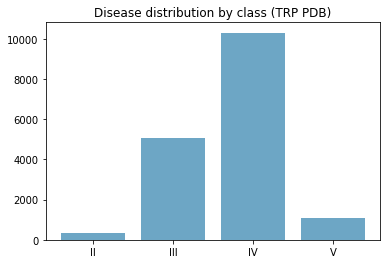

In [ ]:
disease_by_class()

# TRs interactions:  number of interactors in general


**Total and means interactors**

In [ ]:
import seaborn as sns
from IPython.display import Image

def interactors_to_file(file, type):
    df_interactors = []

    with open(file) as file:
        for line in file:
            if 'IntAct;' in line:
                entry = line.split(';')[1].strip()
                interactors = line.split(';')[2].split('.')[0].strip()

                df_interactors.append(
                    {
                        'Entry': entry,
                        'Dataset': type,
                        'IntAct': int(interactors)
                    }
                )

    df_interactors = pd.DataFrame(df_interactors)
    return df_interactors

def execute_t_test(distributions_df, folder, name, title):

    # statistical test
    repeat_distribution = distributions_df[(distributions_df.Dataset == 'repeat')]['IntAct'].to_numpy()
    non_repeat_distribution = distributions_df[(distributions_df.Dataset == 'no_repeat')]['IntAct'].to_numpy()
    sttest = stats.ttest_ind(repeat_distribution, non_repeat_distribution) # todo media e t test
    # for one tailed, divide the p-value by 2
    mean_rep = round(np.mean(repeat_distribution), 2)
    mean_no_rep = round(np.mean(non_repeat_distribution), 2)
    pvalue = sttest.pvalue / 2
    

    total_interactors_repeat = np.sum(repeat_distribution)
    total_interactors_non_repeat = np.sum(non_repeat_distribution)

    print("Total interactors repeat: " + str(total_interactors_repeat))
    print("Total interactors non repeat: " + str(total_interactors_non_repeat))
    print("Total human interactors: " + str(total_interactors_repeat + total_interactors_non_repeat))

    labels = 'Repeat', 'Non repeat'
    sizes = [total_interactors_repeat, total_interactors_non_repeat]
    explode = (0, 0.1)  # only "explode" the 2nd slice

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.savefig(folder + '/images/pie_repeat_vs_no_repeat.png')
    plt.show()
    plt.clf() 

    print("Repeat and UniProt kernel density estimation")

    sns.displot(distributions_df, x="IntAct", hue="Dataset", kde=True )
    plt.ylim(0, 100)
    plt.xlim(0, 200)
    plt.ylabel("# Proteins")
    plt.xlabel("# Interactors")
    plt.show()
    plt.clf() 

    sns.boxplot(x=distributions_df["Dataset"], y=distributions_df["IntAct"], showmeans=True, notch=True)
    plt.ylim(0, 200)
    plt.savefig(folder + '/images/mean_repeat_vs_no_repeat.png')

    print("Mean repeat: " + str(mean_rep))
    print("Mean non repeat: " + str(mean_no_rep))
    print("Test difference between repeats and background through Student's t test, p-value: " + str(pvalue))
    
    
   
    
def interactors_mean():
    # files from uniprot
    df_uniprots_reference = 'drive/MyDrive/Colab Notebooks/datasets/interactors/uniprot_referenceproteome_intact.txt' # remove repeats
    df_repeats = 'drive/MyDrive/Colab Notebooks/datasets/interactors/repeatsdb_interactors.txt'

    df_repeats_interactors = interactors_to_file(df_repeats, 'repeat')
    df_uniprots_reference_interactors = interactors_to_file(df_uniprots_reference, 'no_repeat')

    distributions_df = pd.concat([df_repeats_interactors, df_uniprots_reference_interactors], ignore_index=True)

    execute_t_test(distributions_df, 'drive/MyDrive/Colab Notebooks/datasets/interactors', 'interactors_distributions', 'interactors')

Total interactors repeat: 19431
Total interactors non repeat: 582907
Total human interactors: 602338


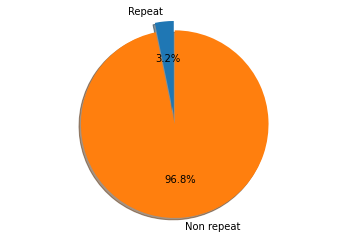

Repeat and UniProt kernel density estimation


<Figure size 432x288 with 0 Axes>

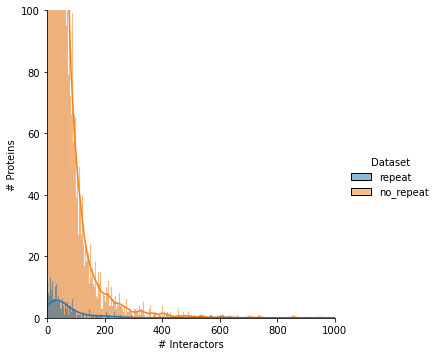

Mean repeat: 70.15
Mean non repeat: 31.19
Test difference between repeats and background through Student's t test, p-value: 1.1286130095072501e-28


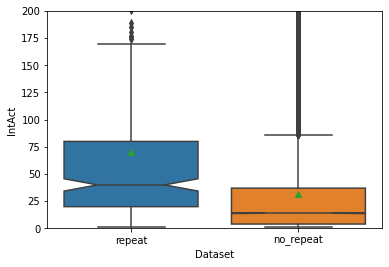

In [ ]:
interactors_mean()

After comparing the distributions statistically, we can observe that repeat proteins have a higher mean value of interactors, and the distributions are statistically different (as the t test shows).


In [ ]:
def reducefile():
        path = 'drive/MyDrive/Colab Notebooks/datasets/interactors/'
        content = pd.read_csv(path + 'intact.txt', sep='\t')
        columns = ['#ID(s) interactor A', 'ID(s) interactor B',
                   'Feature(s) interactor A', 'Feature(s) interactor B']
        print(len(content), 'total interactions')
        df = [d for d in content[columns].to_numpy() if 'binding' in d[2] or 'binding' in d[3]]
        print(len(df), 'interactions annotated with region')
        # fl = open(path + 'intact_reduced.txt', 'w+')
        # fl.write('\t'.join(columns) + '\n')
        # for row in df:
        #     fl.write('\t'.join(row))
        #     fl.write('\n')

        labels = 'Interactions', 'Interaction region annotated'
        sizes = [len(content) -  len(df) , len(df)]
        explode = (0, 0.1)  # only "explode" the 2nd slice

        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

1155104 total interactions
323030 interactions annotated with region


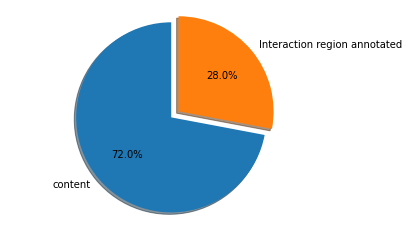

In [ ]:
reducefile()

1155104 total interactions

323030
 interactions annotated with region		

More than 300,000 feature some annotation about the interacting region (on one interactor or the other).

In [ ]:
 import json
 def interacting_repeats_count():
        path = 'drive/MyDrive/Colab Notebooks/datasets/'
        def splitid(key):
            return [d.split(':')[1].split('-')[0] for d in intact[key] if d != '-']

        intact = pd.read_csv(path + 'interactors/intact_reduced.txt', sep='\t')
        repeatsdb = json.loads(open(path + 'uniprots.json').read())
        intact_ids = set(splitid('#ID(s) interactor A')).union(
            set(splitid('ID(s) interactor B'))
        )
        repeatsdb_ids = set([d['uniprot_id'] for d in repeatsdb])
        dataset = repeatsdb_ids & intact_ids
        print(len(dataset), 'entries included in RepeatsDB')

In [ ]:
interacting_repeats_count()

575 entries included in RepeatsDB


# TRs interactions: Repeats in hubs vs non hubs

Although hubs in protein–protein interaction networks have been defined using several criteria, the definition of hubs as proteins with five or more interactions has been shown to be robust (https://onlinelibrary.wiley.com/doi/full/10.1002/pro.425).
Hence I consider proteins that have > 5 interactors as hubs.
I want to calculate how many hubs proteins are also repeats.

In [ ]:
def repeats_in_hubs():
    # files from uniprot
    df_uniprots_reference = 'drive/MyDrive/Colab Notebooks/datasets/interactors/uniprot_referenceproteome_intact.txt' # remove repeats
    df_repeats = 'drive/MyDrive/Colab Notebooks/datasets/interactors/repeatsdb_interactors.txt'
    df_repeats_interactors = interactors_to_file(df_repeats, 'repeat')
    interactors_5plus_rep = df_repeats_interactors[df_repeats_interactors['IntAct'].astype(int) > 5]
    interactors_5minus_rep = df_repeats_interactors[df_repeats_interactors['IntAct'].astype(int) < 5]

    df_uniprots_reference_interactors = interactors_to_file(df_uniprots_reference, 'no_repeat')
    interactors_5plus_no_rep = df_uniprots_reference_interactors[df_uniprots_reference_interactors['IntAct'].astype(int) > 5]
    interactors_5minus_no_rep = df_uniprots_reference_interactors[df_uniprots_reference_interactors['IntAct'].astype(int) < 5]
    hub_5plus = pd.concat([interactors_5plus_rep, interactors_5plus_no_rep], ignore_index=True)
    hub_5minus = pd.concat([interactors_5minus_rep, interactors_5minus_no_rep], ignore_index=True)
    total_hub_5plus = len(hub_5plus)
    total_hub_5minus = len(hub_5minus)
    perc_rep_5plus = (len(hub_5plus.loc[(hub_5plus['Dataset'] == 'repeat')]) / total_hub_5plus) * 100
    perc_rep_5minus = (len(hub_5minus.loc[(hub_5minus['Dataset'] == 'repeat')]) / total_hub_5minus) * 100

    df = pd.DataFrame({'domains': ['Repeating','Repeating'], 'legend': ['hub','no hub'], '% of proteins': [perc_rep_5plus, perc_rep_5minus]})

    sns.catplot(x='domains', y='% of proteins', hue='legend', kind='bar', data=df)
    plt.ylim(0, 5)
    plt.show()

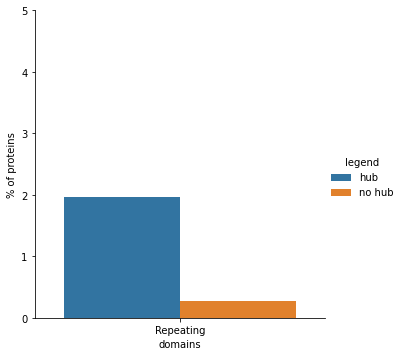

In [ ]:
repeats_in_hubs()

We investigated the prevalence of repeating domains in hubs and non-hubs. A total of 1.97% hubs contained at least one repeating domain when compared with 0.27% in non-hubs. Thus, more hubs had repeating domains than non-hubs.

# TRs interactions: where with respect to the repeat region

Creating a file with both interactors and regions info.

In [15]:
import json
def parselocation(loc):
        resrange = []
        try:
            key, val = loc.split(':')
            # TODO: deal with n-nand c-c notations
            if '?' not in val and 'n' not in val and 'c' not in val:
                for value in val.split(','):
                    if '..' in value:
                        resrange += range(int(value.split('-')[0].split('..')[1]) - 1, int(value.split('-')[1].split('..')[0]))
                    else:
                        resrange += range(int(value.split('-')[0])-1, int(value.split('-')[1].split('(')[0]))
        except:
            return resrange
        return resrange

def repeats_interactors():
    path = 'drive/MyDrive/Colab Notebooks/datasets/interactors'

    def splitid(key):
        return [d.split(':')[1].split('-')[0] for d in intact[key] if d != '-']

    intact = pd.read_csv(path + '/intact_reduced.txt', sep='\t')
    repeatsdb = json.loads(open(path + '/../uniprots.json').read())
    intact_ids = set(splitid('#ID(s) interactor A')).union(
        set(splitid('ID(s) interactor B'))
    )
    repeatsdb_ids = set([d['uniprot_id'] for d in repeatsdb])
    dataset = repeatsdb_ids & intact_ids


    finaldic = {u: [] for u in dataset}
    for index, row in intact.iterrows():
        a = row['#ID(s) interactor A'].split(':')[1].split('-')[0]
        b = row['ID(s) interactor B'].split(':')[1].split('-')[0] if row['ID(s) interactor B'] != '-' else None
        if a in dataset:
            if 'binding' in row['Feature(s) interactor A']:
                finaldic[a].append({
                    'interactor': b,
                    'location': row['Feature(s) interactor A']
                })
        if b and b in dataset:
            if 'binding' in row['Feature(s) interactor B']:
                finaldic[b].append({
                    'interactor': a,
                    'location': row['Feature(s) interactor B']
                })
    repdic = {u['uniprot_id']: u for u in repeatsdb}
    reducedfinaldic = {
        u: {
            'interactions': finaldic[u],
            'repeats': repdic[u]
        } for u in finaldic if finaldic[u]}
    open(path + '/intact_dataset.json', 'w+').write(json.dumps(reducedfinaldic))

    dataset = json.loads(open(path + '/intact_dataset.json').read())
    interestingtypes = set(['sufficient binding region', 'necessary binding region',
                            'direct binding region', 'binding-associated region'])
    filtered_dataset = [d for d in dataset if interestingtypes & set(
        [loc.split(':')[0] for inte in dataset[d]['interactions'] for loc in inte['location'].split('|')]
    )]
    for protein in filtered_dataset:
        prange = range(len(dataset[protein]['repeats']['uniprot_sequence']))
        # print(protein, len(prange))
        repeat_array = [1 if index in set([ii
                                           for reg in dataset[protein]['repeats']['repeatsdb_consensus_one'] for ii
                                           in range(
                reg['start'] - 1, reg['end'])]) else 0
                        for index in prange]
        interaction_array = [1 if index in set(
            [ii for inte in dataset[protein]['interactions'] for loc in inte['location'].split('|')
             for ii in parselocation(loc)]
        ) else 0 for index in prange]
        dataset[protein]['repeat_array'] = repeat_array
        dataset[protein]['interaction_array'] = interaction_array
        open(path + '/intact_dataset_arrays.json', 'w+').write(json.dumps(dataset))

In [16]:
repeats_interactors()

Creating a table with interactions and repeat info by char.

In [21]:
def repeats_interactors_table():
    repeats_interactors_table = []
    df_repeats_interactors = 'drive/MyDrive/Colab Notebooks/datasets/interactors/intact_dataset_arrays.json'
    df_repeats_interactors = json.loads(open(df_repeats_interactors).read())
    for unp in df_repeats_interactors:
        sequence = df_repeats_interactors[unp]['repeats']['uniprot_sequence']
        for idx, char in enumerate(sequence):
            int_reg = 0
            rep_reg = 0
            for ch in df_repeats_interactors[unp]['repeats']['pdb_chains']:
                if idx in range(int(ch['start']), int(ch['end'])):
                    rep_reg = 1
            for interactor in df_repeats_interactors[unp]['interactions']:
                regions = interactor['location'].split('|')
                for reg in regions:
                    if 'region:' in reg:
                        if ',' in reg:
                            multi_reg = reg.split('region:')[1].split(',')
                            for r in multi_reg:
                                st = r.split('-')[0]
                                end = r.split('-')[1]
                                if '..' in st:
                                    st = st.split('..')[0]
                                    end = end.split('..')[0]
                                if '(' in r:
                                    end = end.split('(')[0]
                                    if st != '?' and end != '?':
                                        if idx in range(int(st), int(end)):
                                            int_reg = 1
                                if '|' in r:
                                    end = end.split('|')[0]
                                    if st != '?' and end != '?':
                                        if idx in range(int(st), int(end)):
                                            int_reg = 1
                        else:
                            st = reg.split('region:')[1].split('-')[0]
                            end = reg.split('region:')[1].split('-')[1]
                            if '..' in st:
                                st = st.split('..')[0]
                                end = end.split('..')[0]
                            if '(' in reg:
                                end = end.split('(')[0]
                                if st != '?' and end != '?':
                                    if idx in range(int(st), int(end)):
                                        int_reg = 1
                            if '|' in reg:
                                end = end.split('|')[0]
                                if st != '?' and end != '?':
                                    if idx in range(int(st), int(end)):
                                        int_reg = 1

            repeats_interactors_table.append(
                {
                    'Entry': unp,
                    'Char': char,
                    'Interacting region': int_reg,
                    'Repeat region': rep_reg
                }
            )
    repeats_interactors_table = pd.DataFrame(repeats_interactors_table)

    repeats_interactors_table.to_csv('drive/MyDrive/Colab Notebooks/datasets/interactors/repeats_interactors_table.tsv', sep='\t', index=False)


In [22]:
repeats_interactors_table()

In [23]:
table = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/interactors/repeats_interactors_table.tsv', sep='\t', index_col=0) #to read the file
table

,Char,Interacting region,Repeat region
Entry,,,
O60486,M,0,0
O60486,E,0,0
O60486,V,0,0
O60486,S,0,0
O60486,R,0,0
...,...,...,...
Q96QK1,E,0,0
Q96QK1,G,0,0
Q96QK1,L,0,0


In [29]:
def coverage():
    table = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/interactors/repeats_interactors_table.tsv', sep='\t')
    int_reg_rep_reg = len(table.loc[(table['Interacting region'] == 1) & (table['Repeat region'] == 1)])
    int_reg = len(table.loc[(table['Interacting region'] == 1)])
    rep_reg = len(table.loc[(table['Repeat region'] == 1)])
    int_coverage = str(round((int_reg_rep_reg / int_reg) * 100, 2))
    reg_coverage = str(round((int_reg_rep_reg / rep_reg) * 100, 2))
    print('coverage interacting residues: ' + int_coverage)
    print('coverage repeat residues: ' + reg_coverage)

In [30]:
coverage()

coverage interacting residues: 64.8
coverage repeat residues: 20.57


65% of interacting residues are also repeat residues.

21% of repeat residues are involved in interactions.